# Term Deposit Predictions
Jacob Macdonald
### Problem Definition
Term deposits are an important mechanism for banks to receive funds they can use in other investments with higher rates of return. Thus, it is of great interest for banks to better understand what factors may contribute to customers deciding to subscribe to a term deposit. In this case study, I developed models describing the relationship between a variety of factors from directed marketing campaigns for term deposits and the likelihood of the targets in question subscribing to a term deposit.
### Data Set
The provided data set was derived from direct marketing campaigns for term deposits of a Portuguese banking institution from May 2008 to November 2010. The marketing campaigns were conducted over the phone, both actively calling a list of clients to sell the deposit and soliciting client calls to the contact center for any other reason. The data set can be downloaded from [UC Irvine's Machine Learning Respository](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing) and was published in the [Decision Support Systems Journal](https://www.sciencedirect.com/science/article/pii/S016792361400061X).

In [1]:
# Importing useful Python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Loading in the data sets
bank_full = pd.read_csv("bank-additional-full.csv", sep=";") #Full data set
bank_partial = pd.read_csv("bank-additional.csv", sep=";") # Data set with 10% of cases (same features as full data set)

In [3]:
# Confirming correct file import
bank_full.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Model Strategy
For model development, I will focus on the partial data set with 10% of the values. This will allow for more convenient testing of computationally demanding machine learning algorithms. A variety of classification machine learning algorithms will be investigated, including logistic regression and random forests.

### Data Cleaning
First and foremost, let's convert the results column "y" from "yes" or "no" to the binary outcomes of 1 or 0, respectively.

In [4]:
bank_partial["y"] = bank_partial["y"].replace(["yes","no"],[1,0])

The feature columns need to be cleaned for a variety of factors that could confound the developed models from:
1. Leaking information from the future
2. Poor formatting
3. Containing redundant data
4. Missing data or needing more processing to be useful

#### Leaking Information from the Future
The aim is to develop a model that will help banking institutions determine clients who will be receptive to term deposit marketing campaigns **in advance**. Thus, features should be omitted if they include information we could not realistically control for future campaigns. Including these in our model could lead to overfitting. Referring to the data dictionary for this data sets reveal a few features that should be excluded for this reason.
* "duration": Call duration cannot be controlled in advance.
* "campaign": It cannot be predicted in advance how many contacts will be performed for a particular person during the campaign.

In [5]:
# Removing these two features from our data set.
bank_partial = bank_partial.drop(['duration','campaign'], axis=1)

#### Poor Formatting
Inspection of the features reveals that this data set has consistent formatting for each category. Thus, no cleaning needs to be done in this respect.

#### Containing Redundant Data
The features "pdays", "previous", and "poutcome" seem to have redundant data. If we include this information and there is a correlation between clients not previously being contacted and willingness to subscribe to a term deposit, this parameter will inflated given its representation in all three of these features. For simplicity, let's only keep one. We will keep "poutcome" because it is most directly relevant to the goal of predicting how amenable a client will be to subscribing to a service.

In [6]:
bank_partial["pdays"].value_counts()

999    3959
3        52
6        42
4        14
7        10
10        8
12        5
5         4
2         4
9         3
1         3
13        2
18        2
16        2
15        2
0         2
14        1
19        1
21        1
17        1
11        1
Name: pdays, dtype: int64

In [7]:
bank_partial["previous"].value_counts()

0    3523
1     475
2      78
3      25
4      14
6       2
5       2
Name: previous, dtype: int64

In [8]:
bank_partial["poutcome"].value_counts()

nonexistent    3523
failure         454
success         142
Name: poutcome, dtype: int64

In [9]:
# Removing the redundant features from our data set.
bank_partial = bank_partial.drop(['pdays','previous'], axis=1)

#### Missing Data or Needing More Processing to be Useful
For this step it is important to remember that missing values in this data set do not appear as NaN, but as the text field "unknown." Approaching this on a feature-by-feature basis:

*Age:* Currently there are 67 unique values for age, ranging from 18 to 88. We will standardize this parameter. This will be done later in the notebook with the economic indicators.

In [10]:
bank_partial["age"].describe()

count    4119.000000
mean       40.113620
std        10.313362
min        18.000000
25%        32.000000
50%        38.000000
75%        47.000000
max        88.000000
Name: age, dtype: float64

*Job:* This feature is a categorical variable with 12 categories (including the unknown column). In the context of this work, we are trying to develop a model to accurately predict who will subscribe to term deposits. A bank will likely have employment information on their own customers, so let's remove the rows with "unknown" values since the bank is unlikely to target these in a future campaign.

In [11]:
bank_partial["job"].value_counts()

admin.           1012
blue-collar       884
technician        691
services          393
management        324
retired           166
self-employed     159
entrepreneur      148
unemployed        111
housemaid         110
student            82
unknown            39
Name: job, dtype: int64

In [12]:
bank_partial = bank_partial[bank_partial["job"] != "unknown"]

*Marital:* This is another categorical feature with 4 values, including the missing values labelled "unknown." As with the previous feature, the missing values comprise a miniscule portion of the data and cannot be adequately inferred. Since the bank would have marriage information on customers it would target with its next campaign, let's remove these unknown values to avoid introducing possible variance into the model with imputation.

In [13]:
bank_partial["marital"].value_counts()

married     2481
single      1144
divorced     444
unknown       11
Name: marital, dtype: int64

In [14]:
bank_partial = bank_partial[bank_partial["marital"] != "unknown"]

*Education:* Another categorical feature with 8 values, including the missing field. This time, the missing field has a non-insignificant number of entries, which suggests we could lose some valuable information if we remove it. In previous studies it has been shown people are likely to not respond to questions or leave them blank if they feel embarassed by their answer. With this in mind, let's assume the unknown values correspond to a group who did not receive any formal education. Let's group them with the single illiterate subject in a new "uneducated" group.

In [15]:
bank_partial["education"].value_counts()

university.degree      1256
high.school             912
basic.9y                568
professional.course     533
basic.4y                418
basic.6y                227
unknown                 154
illiterate                1
Name: education, dtype: int64

In [16]:
bank_partial["education"] = bank_partial["education"].replace(["unknown","illiterate"],"uneducated")
bank_partial["education"].value_counts()

university.degree      1256
high.school             912
basic.9y                568
professional.course     533
basic.4y                418
basic.6y                227
uneducated              155
Name: education, dtype: int64

In [17]:
pd.pivot_table(bank_partial,values="y",index="education").sort_values("y")

,y
education,
basic.9y,0.073944
basic.6y,0.074890
basic.4y,0.088517
high.school,0.106360
professional.course,0.121951
university.degree,0.130573
uneducated,0.154839


*Default:* This parameter was a yes/no binary outcome. However, there is only 1 yes response and many unknowns. The lack of variance in the known values, and large amount of unknowns, suggest this parameter will not be useful to our model. Let's remove this entire feature.

In [18]:
bank_partial["default"].value_counts()

no         3284
unknown     784
yes           1
Name: default, dtype: int64

In [19]:
bank_partial = bank_partial.drop("default",axis=1)

*Housing:* The housing feature is a binary yes/no variable with 105 missing responses. It appears that the following "Loan" feature is missing responses from the same 105 respondants. Let's eliminate these variables, to improve the predictive power of the model when the bank can select who they target based on having all information available. With the missing values removed, we can convert this from "yes"/"no" to a binary 1/0.

In [20]:
bank_partial["housing"].value_counts()

yes        2148
no         1816
unknown     105
Name: housing, dtype: int64

In [21]:
bank_partial = bank_partial[bank_partial["housing"] != "unknown"]
bank_partial["housing"] = bank_partial["housing"].replace(["yes","no"],[1,0])

*Loan:* With the cases having missing values for "housing" removed, there are no remaining missing values for "loan". Let's convert this from a binary "yes"/"no" to 1/0.

In [22]:
bank_partial["loan"].value_counts()

no     3308
yes     656
Name: loan, dtype: int64

In [23]:
bank_partial["loan"] = bank_partial["loan"].replace(["yes","no"],[1,0])

*Contact:* This binary outcome variable will be changed from cellular/telephone to 1/0 to allow for models that don't support mixed data types.

In [24]:
bank_partial["contact"].value_counts()

cellular     2562
telephone    1402
Name: contact, dtype: int64

In [25]:
bank_partial["contact"] = bank_partial["contact"].replace(["cellular","telephone"],[1,0])

*Month:* This a difficult feature as we are missing data for January and February. It appears that the campaign did not run in these months. The large volume of calls over the summer months, shown below, suggests that this is when most of the campaigning was done. However, looking at the bar plot below suggests subscription rates were significantly higher in the months with much fewer clients contacted. This may suggest that the summer saw targeted outgoing calls, where in the winter months they advertised only to customers that called in. For now, we'll leave this parameter in our model, but it might be best to exclude given this imbalance and lack of knowledge on the data collection parameters.

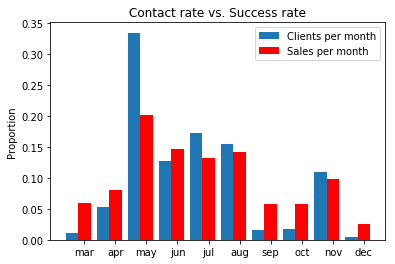

In [26]:
months = bank_partial["month"].value_counts()
labels = ["mar","apr","may","jun","jul","aug","sep","oct","nov","dec"]
months = months[labels]
#sales_rate = pd.pivot_table(bank_partial,values="y",index="month").loc[labels]["y"]
sales_count = pd.pivot_table(bank_partial,values="y",index="month",aggfunc=sum).loc[labels]["y"]

barWidth = 0.4
x1 = np.arange(len(labels))
x2 = [x + barWidth for x in x1]

plt.bar(x1,months/months.sum(),width=barWidth,label='Clients per month')
plt.bar(x2,sales_count/sales_count.sum(),width=barWidth,color='red',label='Sales per month')
plt.xticks([r+barWidth for r in range(len(labels))], labels)
plt.ylabel('Proportion')
plt.title('Contact rate vs. Success rate')
plt.legend()

*Day of week:* The days on which clients were contacted and the proportion of which agreed to term deposits are approximately uniform distributions. These won't contribute much to our model, and thus, this feature is being omitted for efficiency.

In [27]:
bank_partial["day_of_week"].value_counts()

mon    826
thu    824
tue    804
wed    771
fri    739
Name: day_of_week, dtype: int64

In [28]:
pd.pivot_table(bank_partial,values="y",index="day_of_week")

,y
day_of_week,
fri,0.110961
mon,0.118644
thu,0.108010
tue,0.109453
wed,0.103761


In [29]:
bank_partial = bank_partial.drop("day_of_week", axis=1)

*emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed:* These five economic indices will be included because they all characterize different aspects of the economy, which has singificant influence on consumer willingness to subscribe to term deposits. All will be standardized.

In [30]:
from sklearn.preprocessing import StandardScaler
scale_features = ["age","emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]
scaler = StandardScaler()
scaler.fit(bank_partial[scale_features])
bank_partial[scale_features] = scaler.transform(bank_partial[scale_features])
bank_partial.head()

C:\Users\jalex\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\jalex\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


,age,job,marital,education,housing,loan,contact,month,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,-0.975467,blue-collar,married,basic.9y,1,0,1,may,nonexistent,-1.202374,-1.178963,-1.231754,-1.326774,-0.910606,0
1,-0.102524,services,single,high.school,0,0,0,may,nonexistent,0.653602,0.717707,0.894988,0.715234,0.335597,0
2,-1.460436,services,married,high.school,1,0,0,jun,nonexistent,0.845600,1.529089,-0.276891,0.776921,0.838688,0
4,0.673426,admin.,married,university.degree,1,0,1,nov,nonexistent,-0.114388,-0.650101,-0.320293,0.332430,0.400687,0
5,-0.781480,services,single,university.degree,0,0,1,sep,failure,-0.754380,1.070856,0.656272,-1.574098,-2.748042,0


With our feature columns cleaned and refined, the last step before model development is to convert categorical columns into numerical columns with dummy variables. The columns we need to transform are "job", "marital", "education", "month", and "poutcome". For all of these features except for "month" we will generate k-1 dummies. "month" will receive k dummies because we do not wish to confuse the kth month with January or February, which are absent in our model.

In [31]:
dummy_df = pd.get_dummies(bank_partial[["job","marital","education","poutcome"]],drop_first=True)
bank_partial = pd.concat([bank_partial, dummy_df], axis=1)
bank_partial = bank_partial.drop(["job","marital","education","poutcome"], axis=1)

dummy_df = pd.get_dummies(bank_partial["month"])
bank_partial = pd.concat([bank_partial, dummy_df], axis=1)
bank_partial = bank_partial.drop(["month"], axis=1)

bank_partial.head(10)

,age,housing,loan,contact,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,...,apr,aug,dec,jul,jun,mar,may,nov,oct,sep
0,-0.975467,1,0,1,-1.202374,-1.178963,-1.231754,-1.326774,-0.910606,0,...,0,0,0,0,0,0,1,0,0,0
1,-0.102524,0,0,0,0.653602,0.717707,0.894988,0.715234,0.335597,0,...,0,0,0,0,0,0,1,0,0,0
2,-1.460436,1,0,0,0.845600,1.529089,-0.276891,0.776921,0.838688,0,...,0,0,0,0,1,0,0,0,0,0
4,0.673426,1,0,1,-0.114388,-0.650101,-0.320293,0.332430,0.400687,0,...,0,0,0,0,0,0,0,1,0,0
5,-0.781480,0,0,1,-0.754380,1.070856,0.656272,-1.574098,-2.748042,0,...,0,0,0,0,0,0,0,0,0,1
6,-0.781480,1,0,1,-0.754380,1.070856,0.656272,-1.576980,-2.748042,0,...,0,0,0,0,0,0,0,0,0,1
7,0.091464,1,0,1,-0.114388,-0.650101,-0.320293,0.332430,0.400687,0,...,0,0,0,0,0,0,0,1,0,0
8,-0.878474,0,0,1,-0.114388,-0.650101,-0.320293,0.310522,0.400687,0,...,0,0,0,0,0,0,0,1,0,0
9,-0.490499,0,0,0,0.653602,0.717707,0.894988,0.715234,0.335597,0,...,0,0,0,0,0,0,1,0,0,0
10,-1.460436,1,0,1,0.845600,0.586783,-0.472204,0.774615,0.838688,0,...,0,0,0,1,0,0,0,0,0,0


Finally, before we being making models, let's check if there are any duplicate rows and remove them to avoid overfitting to certain cases.

In [60]:
print("Number of rows before duplicate removal: ", bank_partial.shape[0])
n_duplicates = bank_partial.duplicated().sum()
print("Number of duplicates: ",n_duplicates)
bank_partial = bank_partial.drop_duplicates()
print("Number of rows after duplicate removal: ",bank_partial.shape[0])

Number of rows before duplicate removal:  3864
Number of duplicates:  0
Number of rows after duplicate removal:  3864


### Model Development
Now that the features are cleaned and refined, we are ready to implement our models. In absence of a proper, separate test set of data, we will hold out a portion of the data for later model testing. These will be the last 500 points of our data set (approximately 12% of the total data). We are using the last 500 points instead of a random subset given the time dependence of this data. 

In [61]:
# Importing relevant machine learning classes and functions from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [62]:
# Let's break up our data into a training set and a validation set which will be set aside for later. We'll reserve 500 rows for validation.
bank_partial.shape

(3864, 40)

In [63]:
train_group = bank_partial.iloc[:3364,:] # This will be further split into training and validation sets for cross-validation
holdout_group = bank_partial.iloc[3364:,:]  # To be withheld until the models have been trained and cross-validated

### Cross-Validation
Given the temporal nature of this data set.

In [64]:
tss = TimeSeriesSplit(n_splits=5)

# Indicate relevant dependent and target features for modeling.
features = list(train_group.columns.drop("y"))
target = "y"

In [74]:
def select_models(df,features,target):

    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"],
                    "class_weight": [None,"balanced"],
                    "max_iter": [1000],
                    "warm_start": [True,False]
                }
        },
        {
            "name": "MLPClassifier",
            "estimator": MLPClassifier(),
            "hyperparameters":
                {
                    "hidden_layer_sizes": [(10,),(10,10),(20,)],
                    "max_iter": [10000],
                    "warm_start": [True,False]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(),
            "hyperparameters":
                {
                    "n_estimators": [5, 10, 20],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5],
                    "warm_start": [True,False]
                }
        },
        {
            "name": "SVC",
            "estimator": SVC(),
            "hyperparameters":
                {
                    "kernel": ["linear","poly","rbf","sigmoid"],
                    "gamma": ['auto','scale'],
                    "class_weight": [None,"balanced"],
                }
        }
    ]

    for model in models:
        print(model['name'])
        print('-'*len(model['name']))

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            scoring='roc_auc',
                            cv=tss.split(df))
        grid.fit(df[features],df[target])
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models

In [75]:
models = select_models(train_group, features, target)

LogisticRegression
------------------
Best Score: 0.7356434564947043
Best Parameters: {'class_weight': None, 'max_iter': 1000, 'solver': 'newton-cg', 'warm_start': True}

MLPClassifier
-------------
Best Score: 0.6864505923439378
Best Parameters: {'hidden_layer_sizes': (10,), 'max_iter': 10000, 'warm_start': False}

RandomForestClassifier
----------------------
Best Score: 0.7606429624034605
Best Parameters: {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 5, 'warm_start': False}

SVC
---
Best Score: 0.7467350940700325
Best Parameters: {'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'poly'}



### Applying the Best Model to the Holdout Data